In [139]:
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [140]:
df = pd.read_csv("account_data.csv",parse_dates = True)

In [141]:
a = list(df['accountId'].unique())
df = df[df['accountId']=="5ffdb895b08512986422b08c"]
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [142]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:35]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [143]:
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)

In [144]:
account_data.set_index('date',inplace = True)

In [145]:
account_data = account_data[account_data['sales']>1000] 
account_data = account_data[account_data['sales']<45000]

In [146]:
validate = account_data[['sales','spend', 'clicks', 'impressions', 'orders','keywordId']].tail(1000)
account_data.drop(account_data.tail(1000).index,inplace=True)

In [147]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders']])
dataY = y_scaler.fit_transform(account_data[['sales']])

In [148]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [149]:
account_data.shape

(8470, 10)

In [150]:
hist_window = 1000
horizon = 1000
TRAIN_SPLIT = 6000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [151]:
print ('Single window of past history')
print(x_train_multi[0])
print(len(x_train_multi[0]))
print('\n Target horizon')
print(y_train_multi[0])
print(len(y_train_multi[0]))

Single window of past history
[[6.91878487e-02 1.02688517e-02 8.74439462e-02 5.00051688e-03
  9.75609756e-02]
 [6.14379734e-03 1.18631850e-02 4.70852018e-02 2.83683169e-04
  2.43902439e-02]
 [1.78535332e-01 2.25668922e-02 2.69058296e-01 8.76292501e-03
  3.17073171e-01]
 ...
 [4.14711153e-02 1.65466195e-02 6.72645740e-02 2.30071858e-02
  4.87804878e-02]
 [3.62936324e-02 8.20663629e-03 1.30044843e-01 1.59920376e-02
  4.87804878e-02]
 [1.85561882e-01 9.27238627e-02 2.53363229e-01 2.85077544e-02
  4.87804878e-02]]
1000

 Target horizon
[[0.06183191]
 [0.26803021]
 [0.00758588]
 [0.09330983]
 [0.12113484]
 [0.14432533]
 [0.06855953]
 [0.30879865]
 [0.17701909]
 [0.05168581]
 [0.11908298]
 [0.67435996]
 [0.05300825]
 [0.28582407]
 [0.09089198]
 [0.26004202]
 [0.00872702]
 [0.0406256 ]
 [0.03006979]
 [0.40483709]
 [0.08665084]
 [0.15772181]
 [0.06432649]
 [0.36739728]
 [0.00351976]
 [0.12295086]
 [0.05878338]
 [0.00546183]
 [0.1370968 ]
 [0.14362461]
 [0.07013406]
 [0.17583415]
 [0.06264394]


In [152]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [153]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=16,return_sequences=True),
    tf.keras.layers.LSTM(units=15,return_sequences=True),
    tf.keras.layers.Dense(units=1)
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [154]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_sales_only_LSTM.h5'
EVALUATION_INTERVAL = 10
EPOCHS = 25
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                              ]
                           )

Epoch 1/25
10/10 [==============================] - 199s 20s/step - loss: 0.0252 - val_loss: 0.0276
Epoch 2/25
10/10 [==============================] - 195s 20s/step - loss: 0.0362 - val_loss: 0.0296
Epoch 3/25
10/10 [==============================] - 193s 20s/step - loss: 0.0212 - val_loss: 0.0270
Epoch 4/25
10/10 [==============================] - 192s 20s/step - loss: 0.0359 - val_loss: 0.0309
Epoch 5/25
10/10 [==============================] - 193s 20s/step - loss: 0.0214 - val_loss: 0.0267
Epoch 6/25
10/10 [==============================] - 192s 20s/step - loss: 0.0359 - val_loss: 0.0315
Epoch 7/25
10/10 [==============================] - 193s 20s/step - loss: 0.0216 - val_loss: 0.0265
Epoch 8/25
10/10 [==============================] - 192s 20s/step - loss: 0.0356 - val_loss: 0.0295
Epoch 9/25
10/10 [==============================] - 193s 20s/step - loss: 0.0214 - val_loss: 0.0265
Epoch 10/25
10/10 [==============================] - 194s 20s/step - loss: 0.0351 - val_loss: 0.0287

KeyboardInterrupt: 

In [155]:
Trained_model = tf.keras.models.load_model("Encoder_Decoder_LSTM_Multivariate_sales_only_LSTM.h5")

In [156]:
Trained_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1000, 64)          17920     
                                                                 
 lstm_21 (LSTM)              (None, 1000, 32)          12416     
                                                                 
 lstm_22 (LSTM)              (None, 1000, 16)          3136      
                                                                 
 lstm_23 (LSTM)              (None, 1000, 15)          1920      
                                                                 
 dense_5 (Dense)             (None, 1000, 1)           16        
                                                                 
Total params: 35,408
Trainable params: 35,408
Non-trainable params: 0
_________________________________________________________________


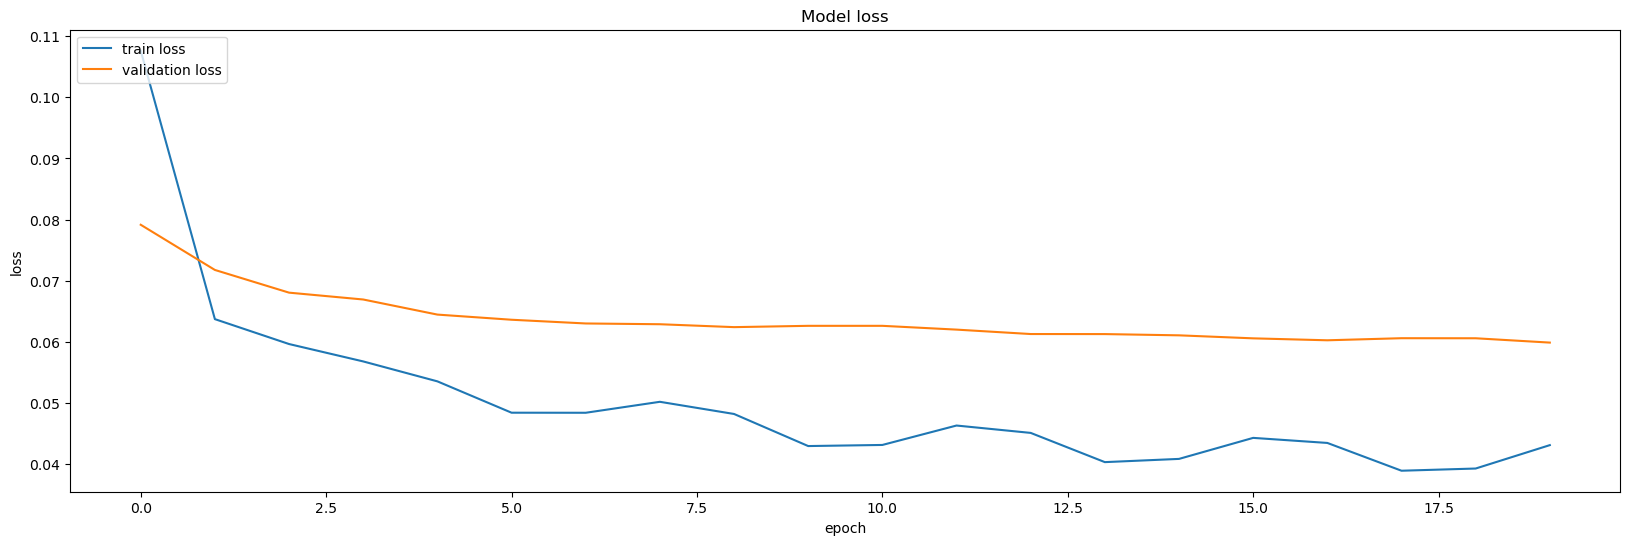

In [157]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [20,6]
plt.show()

In [159]:
data_val = x_scaler.fit_transform(account_data[['sales','spend','orders','clicks','impressions']].tail(1000))
print(data_val)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(data_val.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
print(val_rescaled)
print(val_rescaled.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results = Trained_model.predict(val_rescaled)[0]
print(Predicted_results)
print(len(Predicted_results))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(Predicted_results_Inv_trans)
print(len(Predicted_results_Inv_trans))

[[0.05574944 0.05446305 0.33333333 0.11764706 0.04618956]
 [0.06431877 0.06827946 0.07407407 0.08941176 0.19606339]
 [0.12428871 0.2133392  0.03703704 0.13411765 0.44295952]
 ...
 [0.33844811 0.33373984 0.14814815 0.19529412 0.72526496]
 [0.26283674 0.07090064 0.11111111 0.10588235 0.08462703]
 [0.74575727 0.69723588 0.2962963  0.78352941 0.25808015]]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(1000, 5)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[[[0.05574944 0.05446305 0.33333333 0.11764706 0.04618956]
  [0.06431877 0.06827946 0.07407407 0.08941176 0.19606339]
  [0.12428871 0.2133392  0.03703704 0.13411765 0.44295952]
  ...
  [0.33844811 0.33373984 0.14814815 0.19529412 0.72526496]
  [0.26283674 0.07090064 0.11111111 0.10588235 0.08462703]
  [0.74575727 0.69723588 0.2962963  0.78352941 0.25808015]]]
(1, 1000, 5)
%%%

In [160]:
testing = validate.copy()
testing[['pred_sales']] = Predicted_results_Inv_trans

In [161]:
testing['keywordId'].unique()

array(['178337812269813', '202640426426128', '190918643002238',
       '234598292844815', '115183597326876', '247863105542037',
       '272872700879778', '79454459707340', '85472206701258',
       '87296464240522', '234485565812381', '197034671889267',
       '67530812369819', '116716807274101', '227590663052584',
       '90306352578146', '148684437353570', '210247423029007',
       '13560133409311', '14934981931705', '64265992690180',
       '189229237302837', '185293015123540', '228625472493978',
       '86403799082238', '187760894834115', '67652894855323'],
      dtype=object)

In [162]:
testing[testing['keywordId'] == '85472206701258']

,sales,spend,clicks,impressions,orders,keywordId,pred_sales
date,,,,,,,
2022-12-13,9770.713900,1567.159497,96,31248,3,85472206701258,4954.476074
2022-12-14,11109.085380,1595.504897,97,31316,3,85472206701258,7133.413574
2022-12-15,9627.873996,1619.893577,97,31542,3,85472206701258,7261.804688
2022-12-16,9430.373463,1619.519767,96,31418,3,85472206701258,7169.460938
2022-12-17,10052.875668,1571.065132,93,31059,3,85472206701258,7385.011230
2022-12-18,9389.893579,1591.352447,94,30503,3,85472206701258,7451.970703
2022-12-19,9492.710435,1594.630788,95,30245,3,85472206701258,7346.943359
2022-12-20,8227.015711,1568.606683,95,30105,2,85472206701258,7394.177734
2022-12-21,7982.509616,1561.623125,95,30565,2,85472206701258,7541.391113


In [165]:
max(testing['sales'])

42126.9095018487

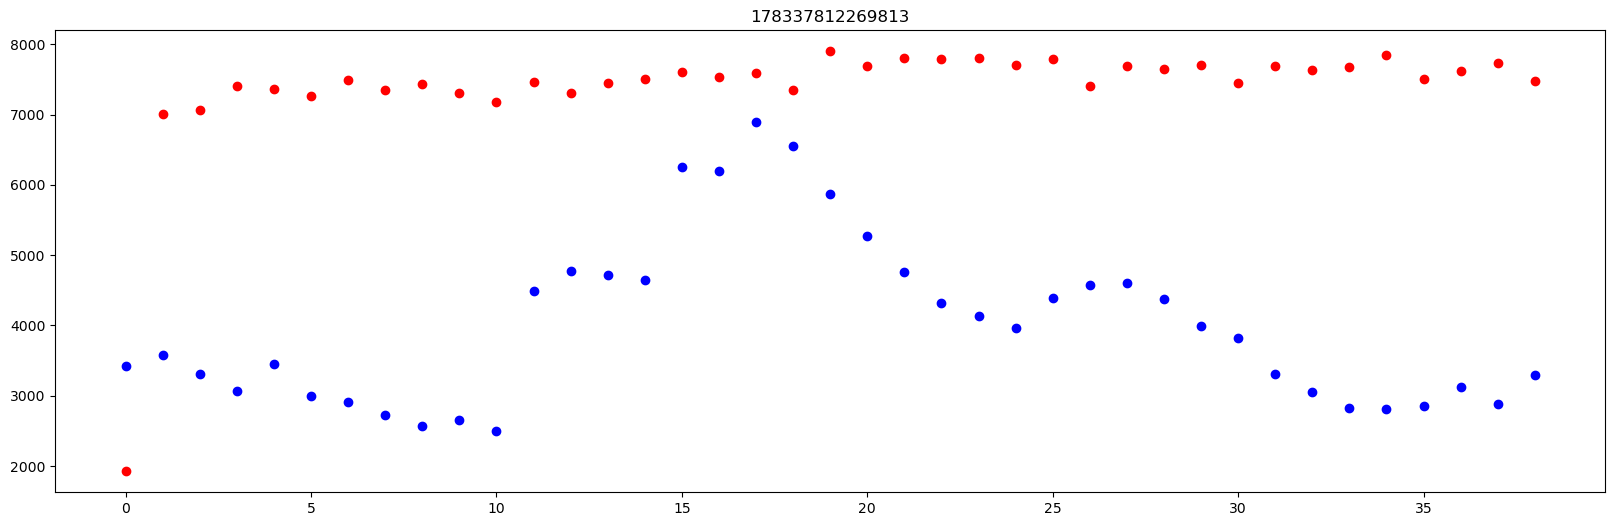

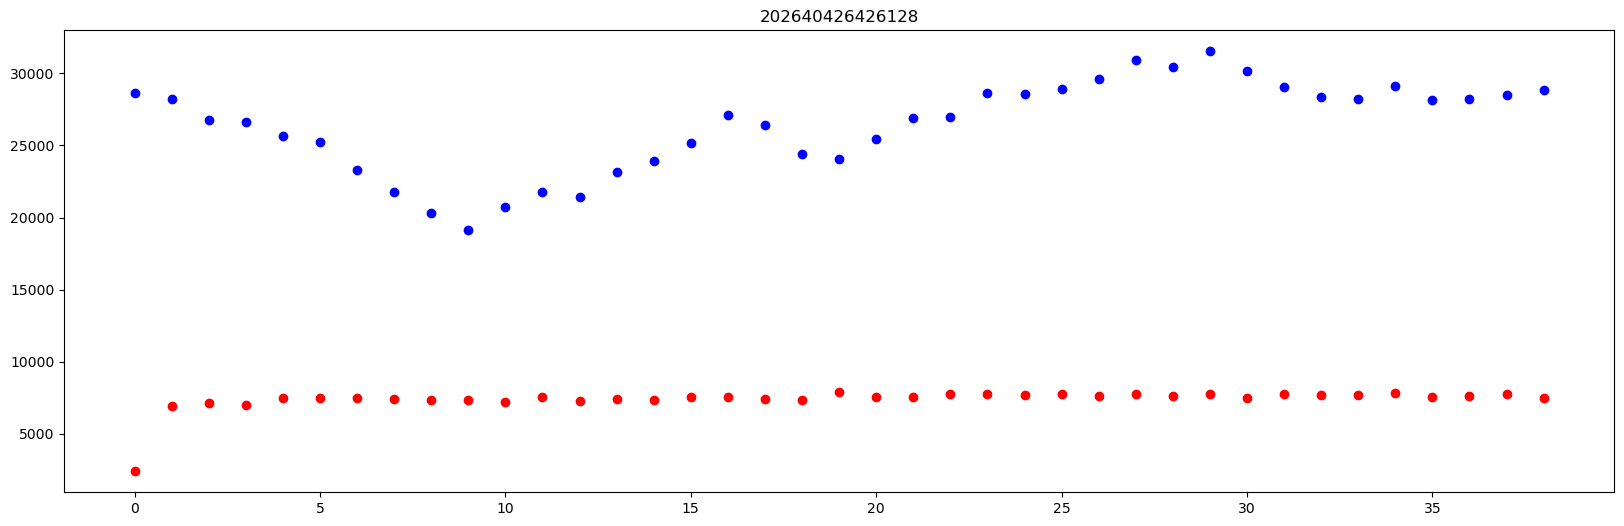

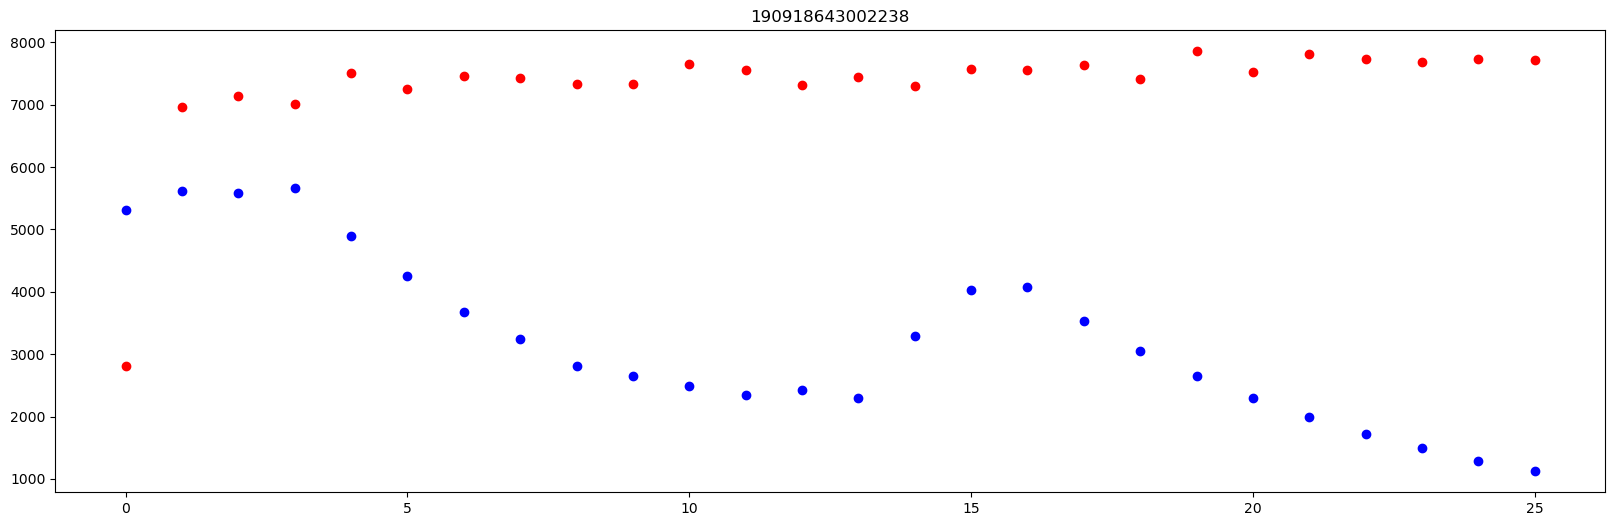

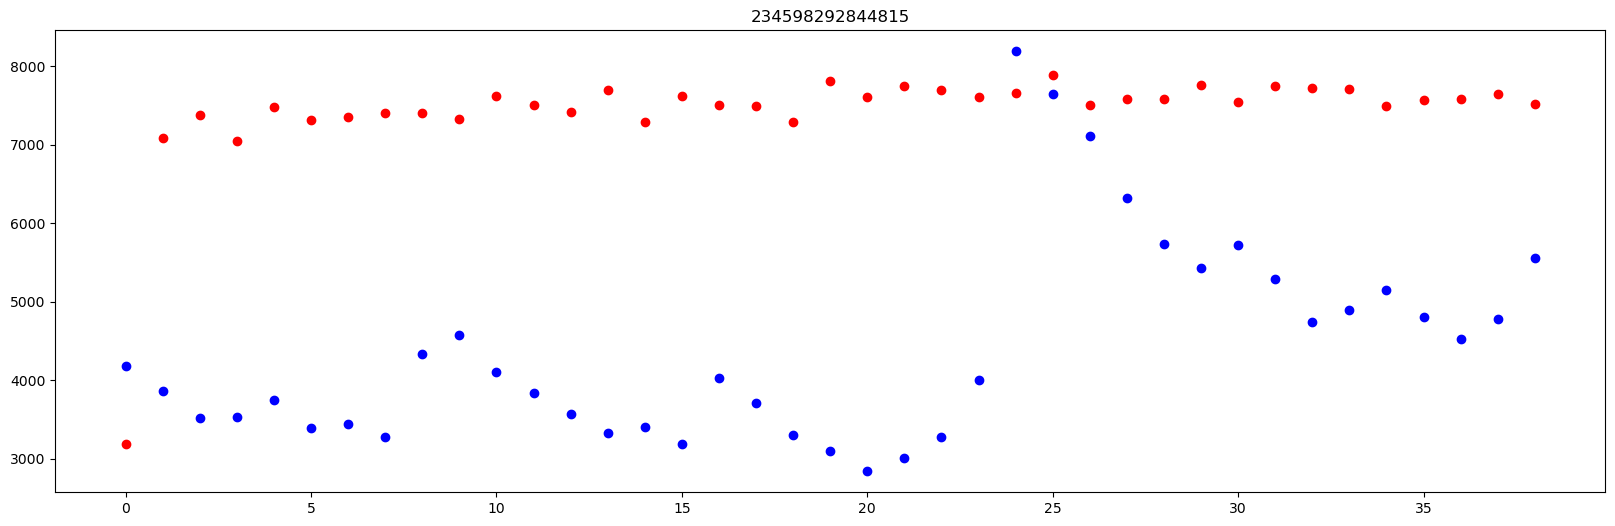

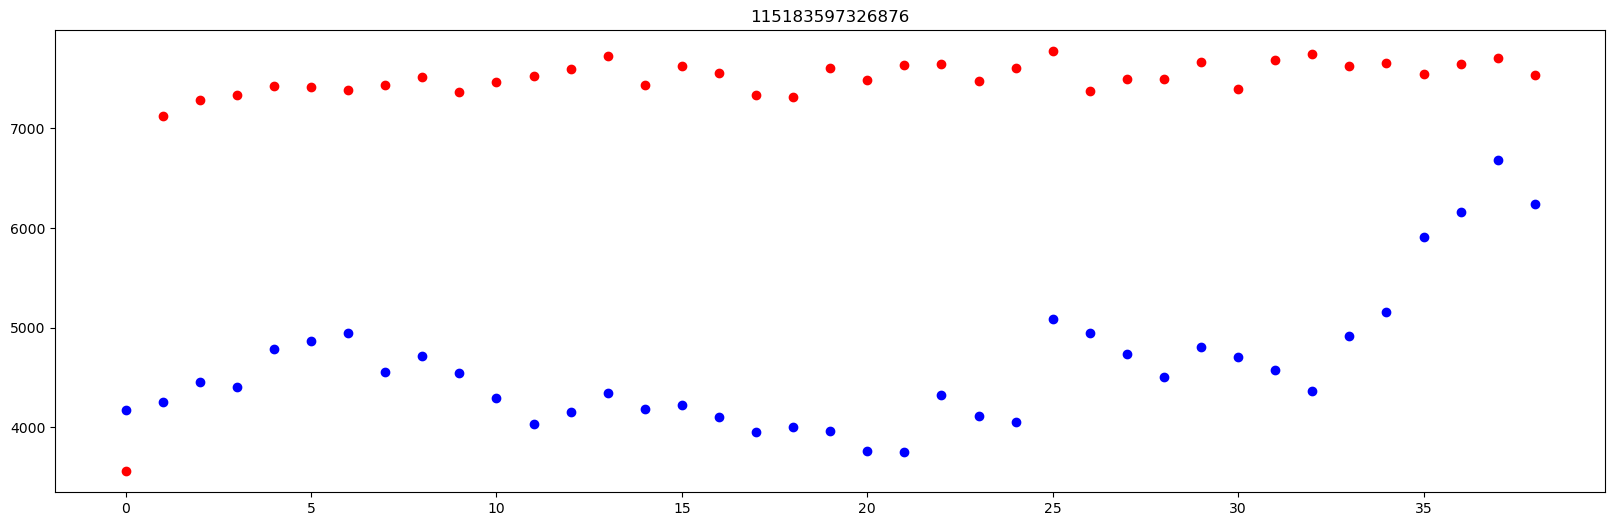

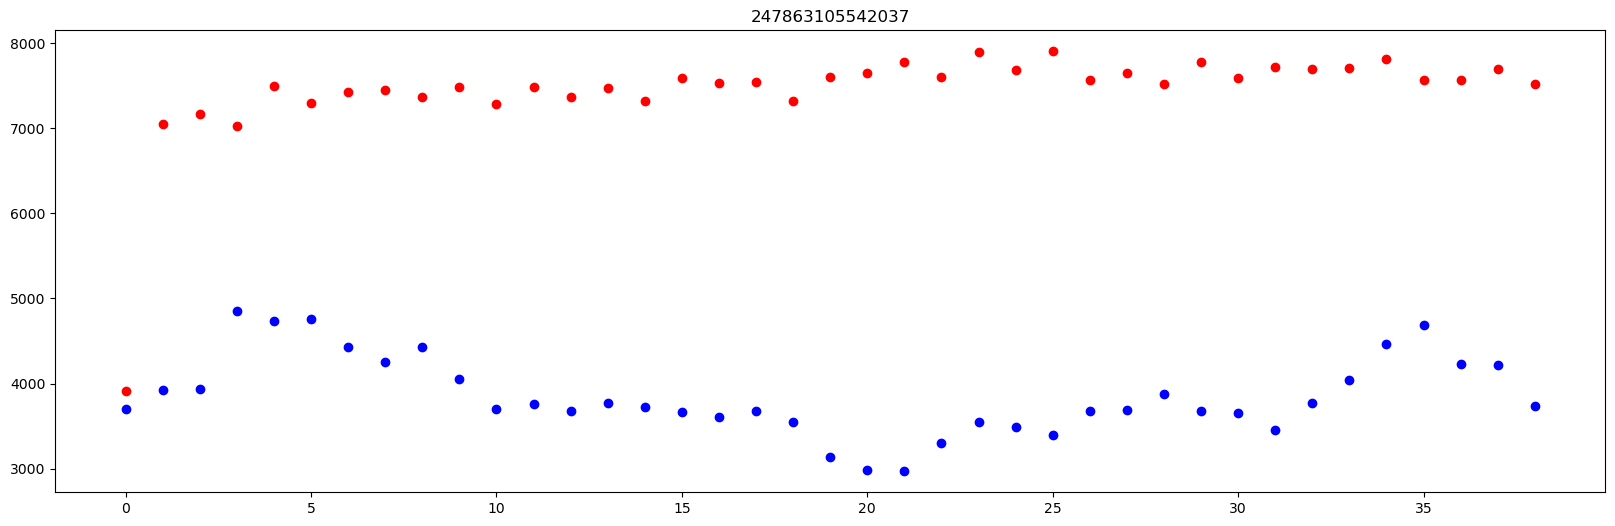

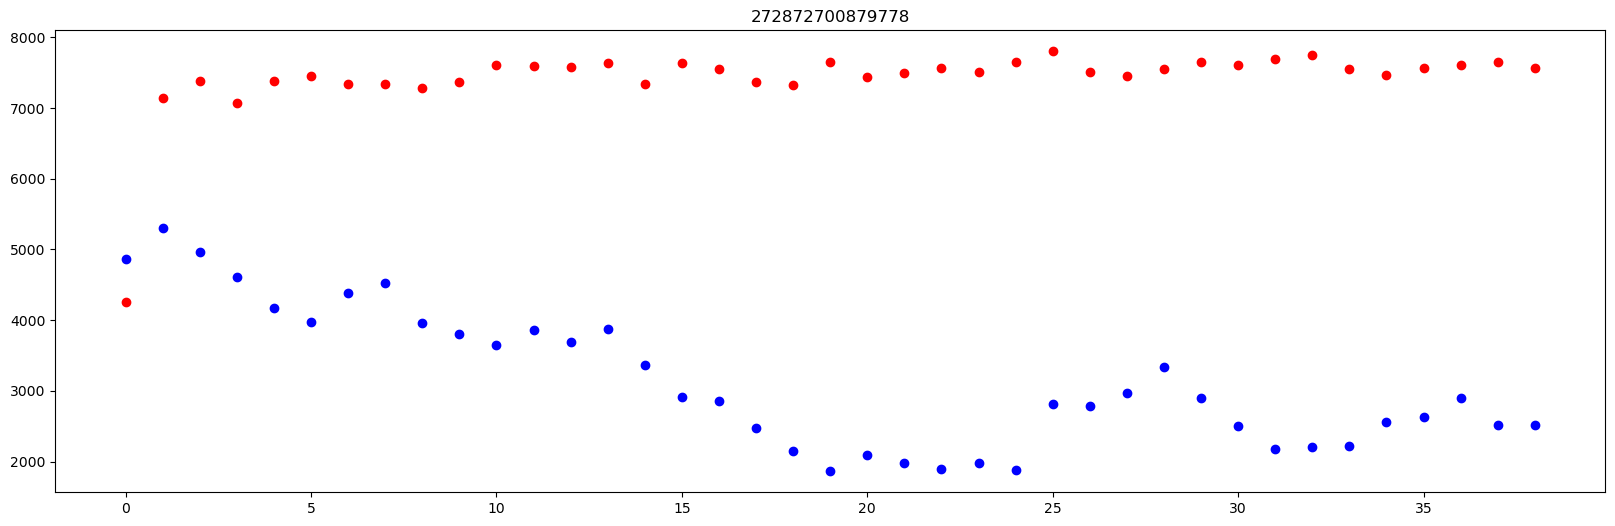

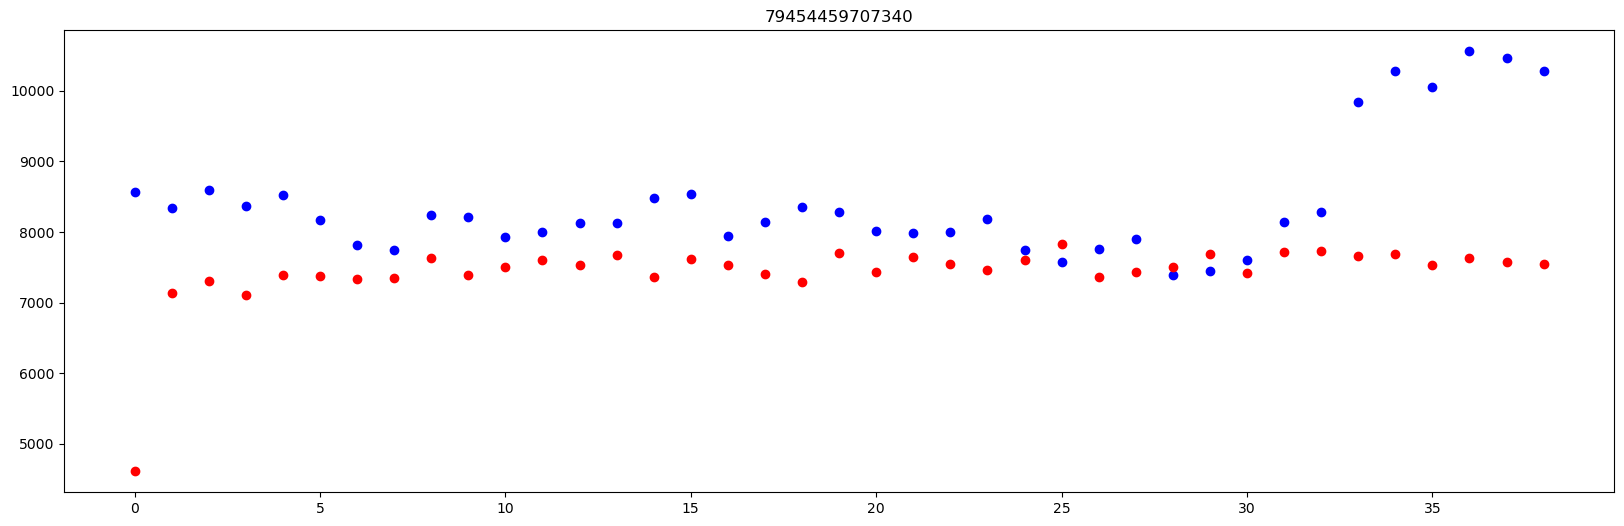

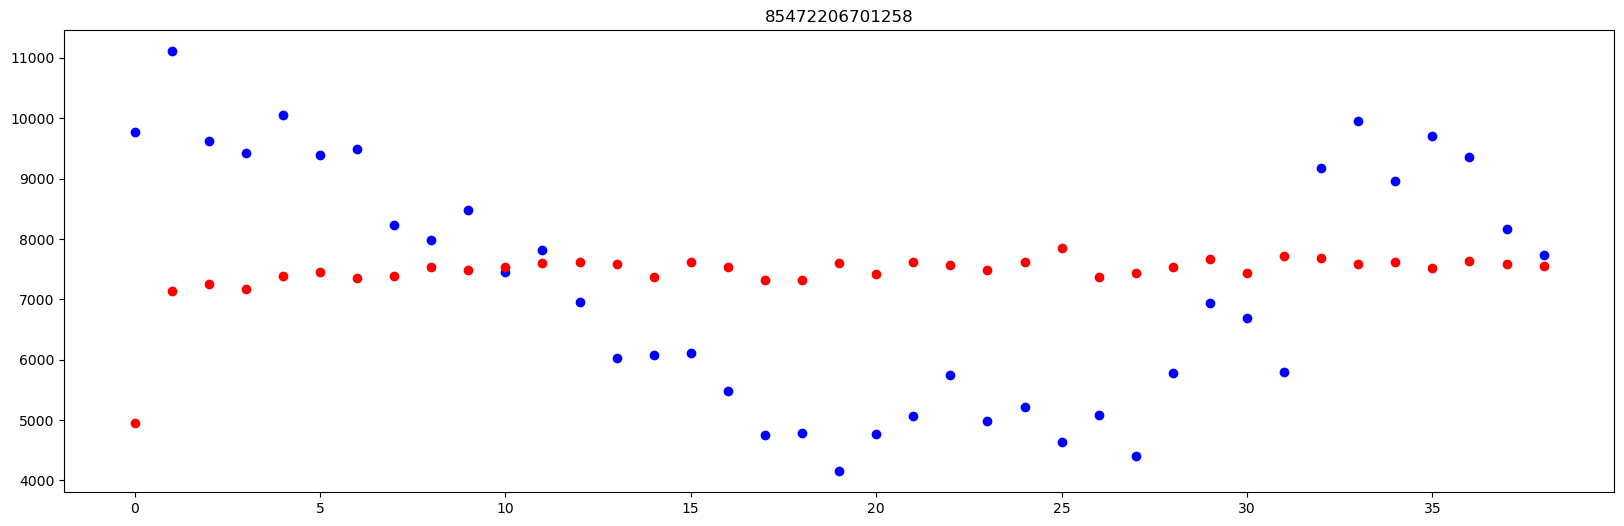

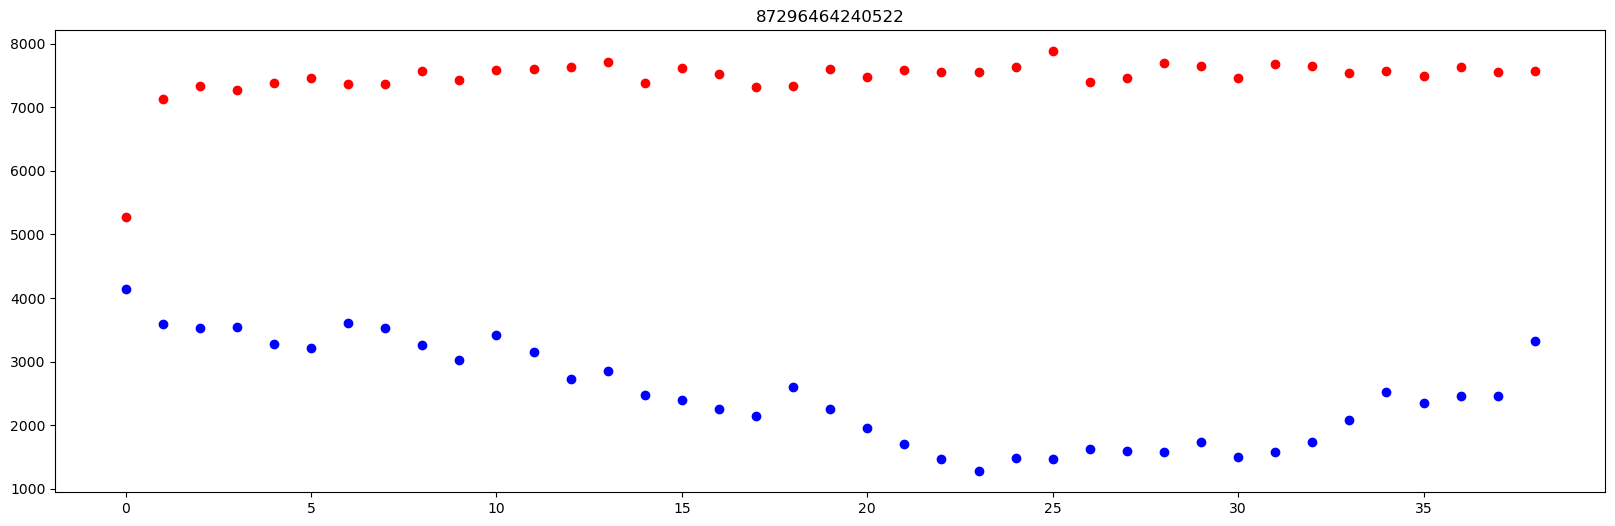

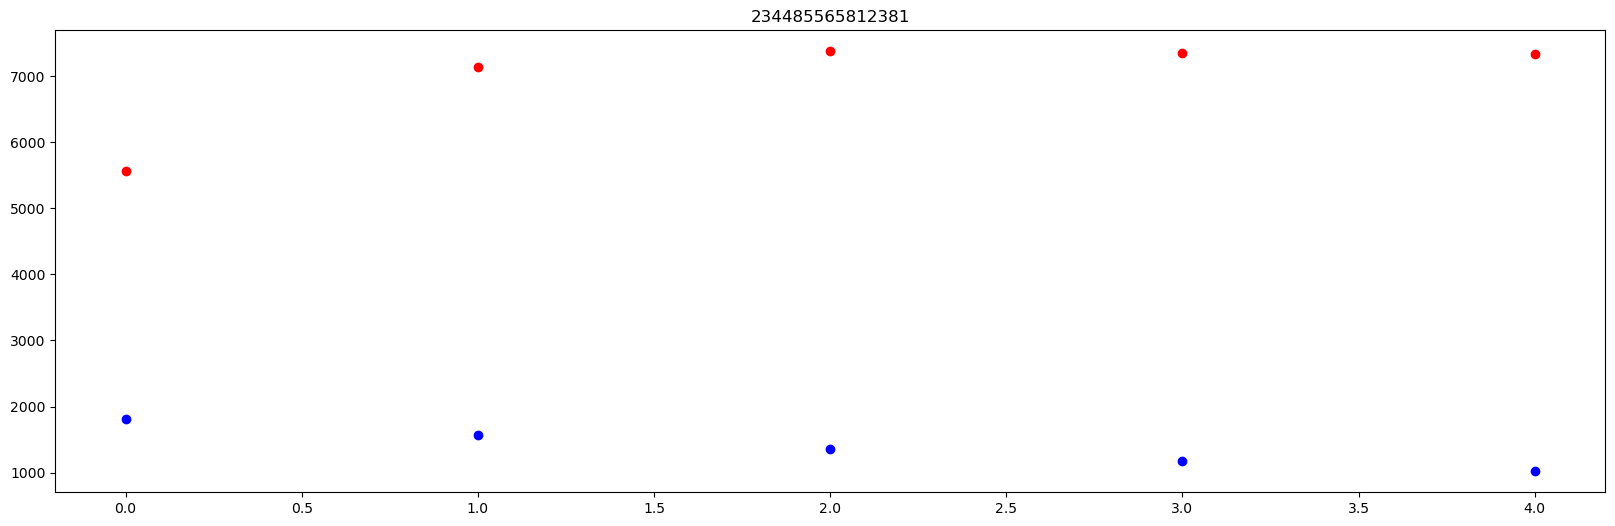

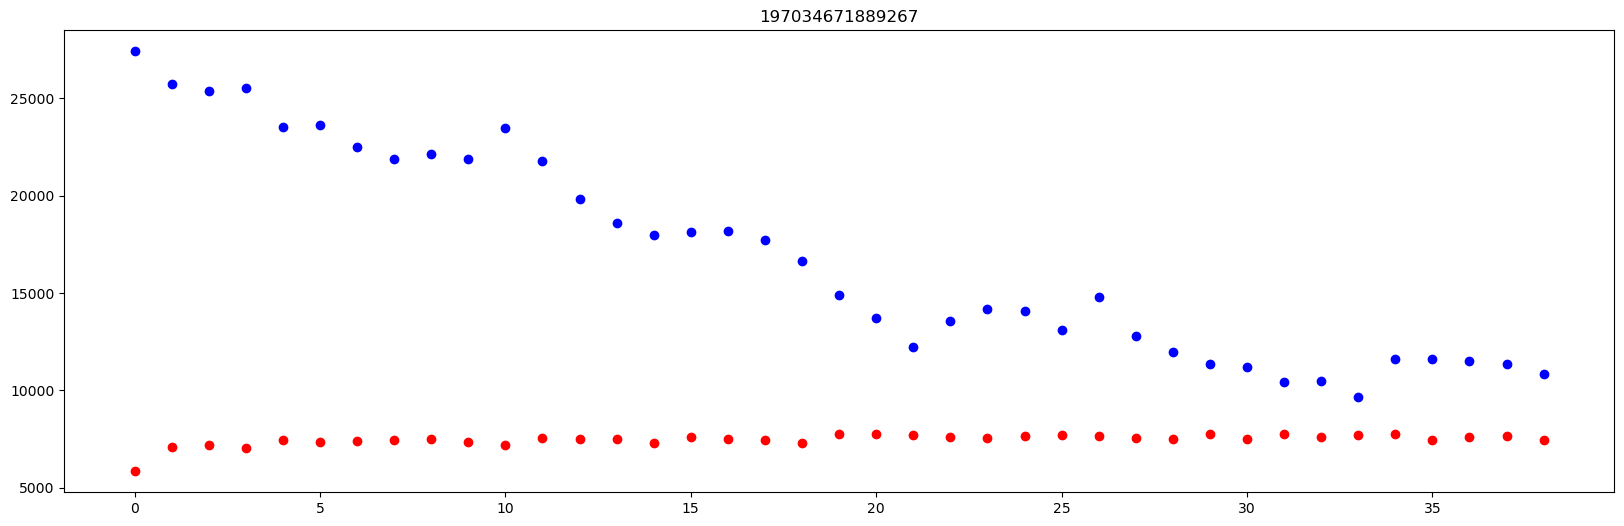

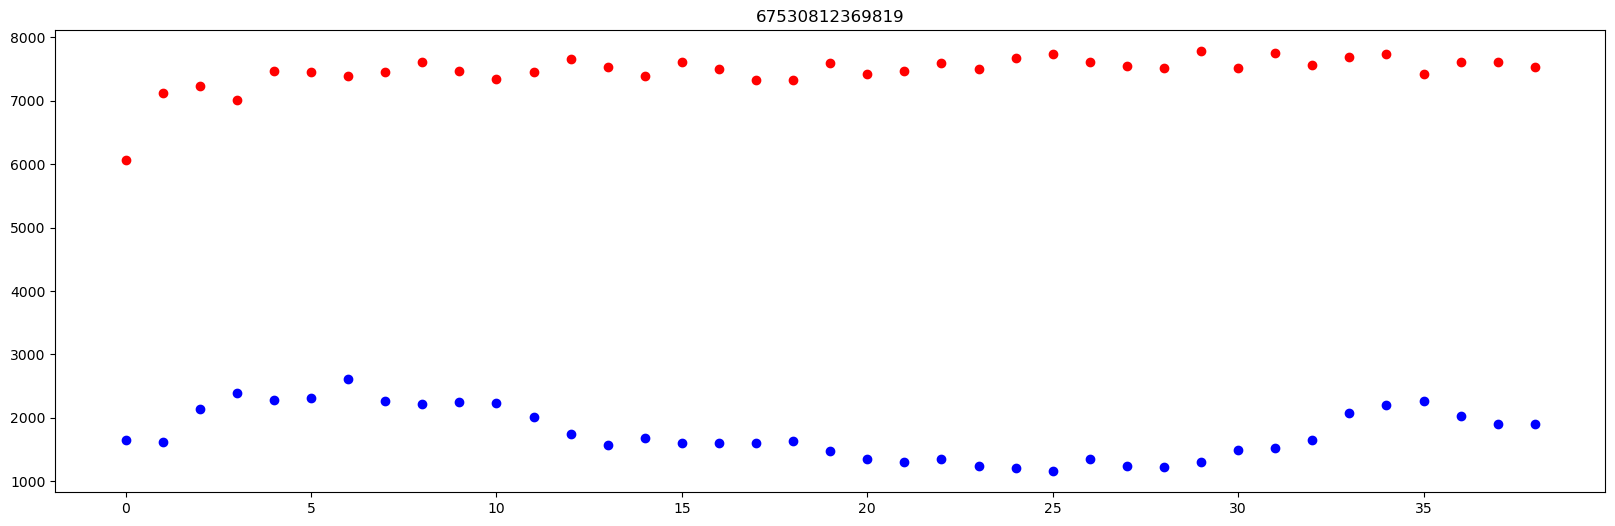

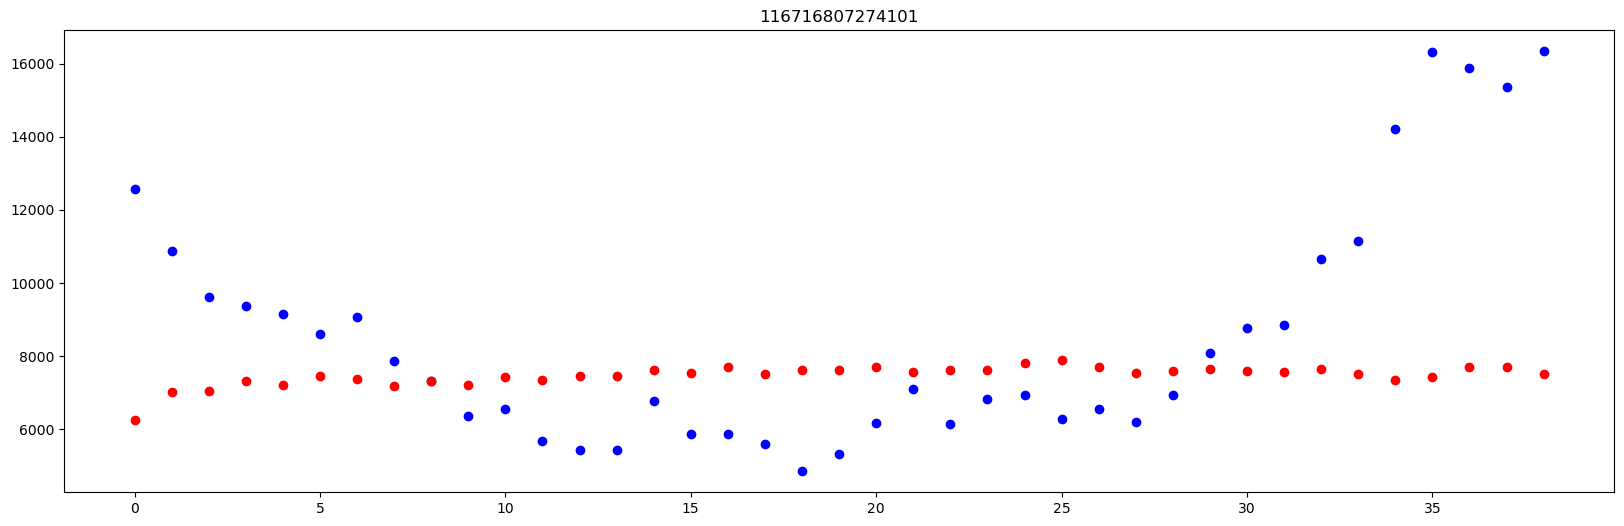

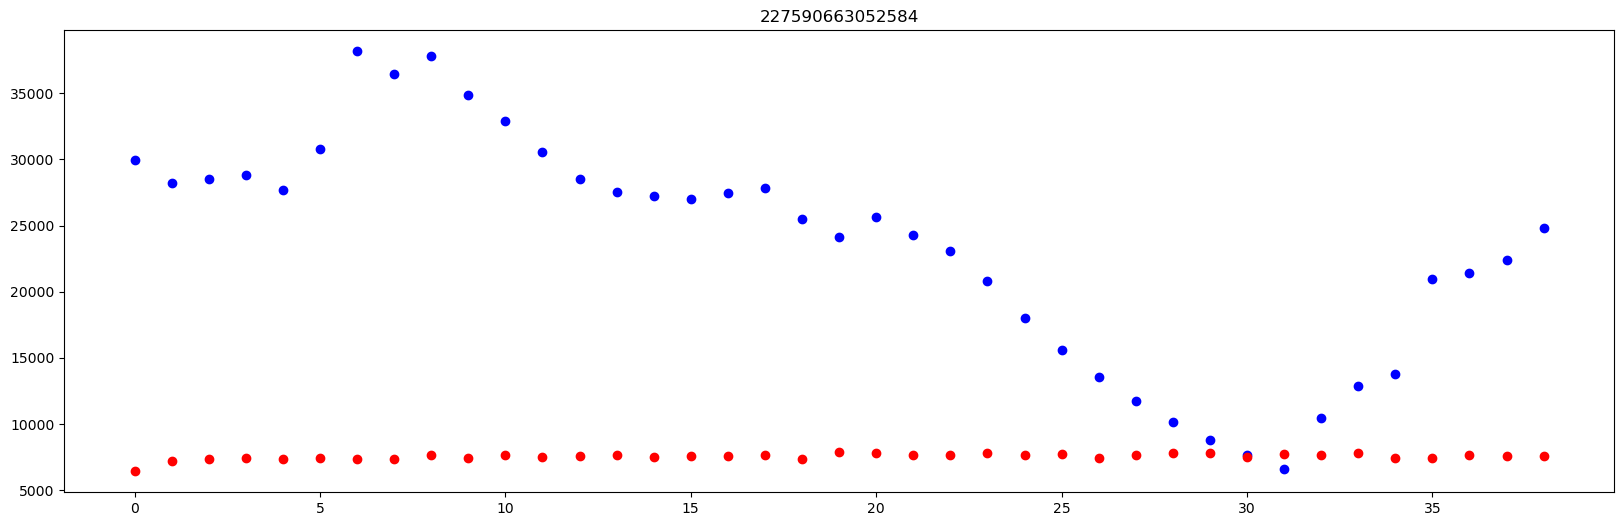

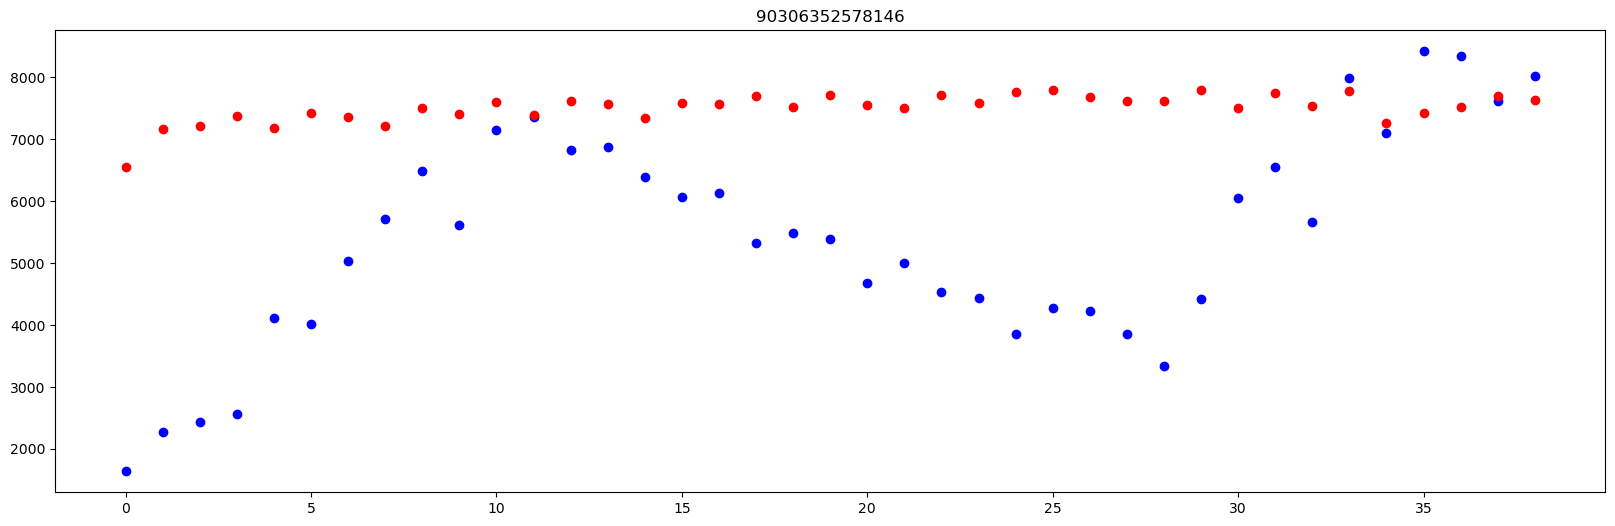

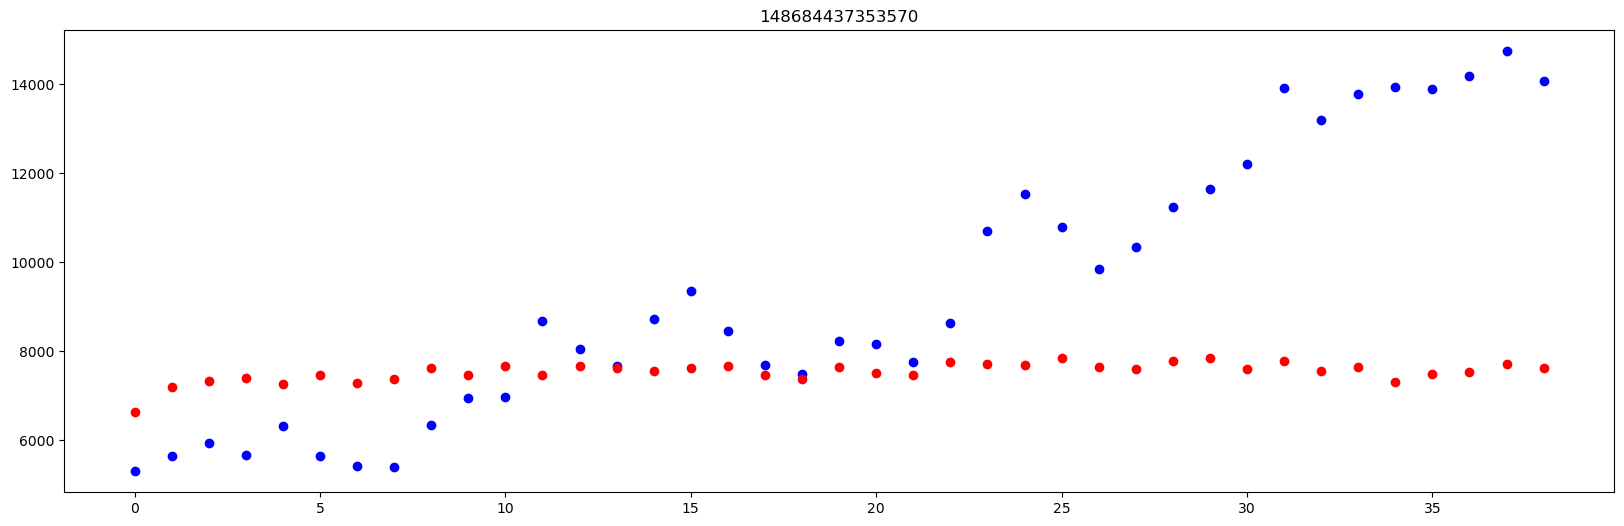

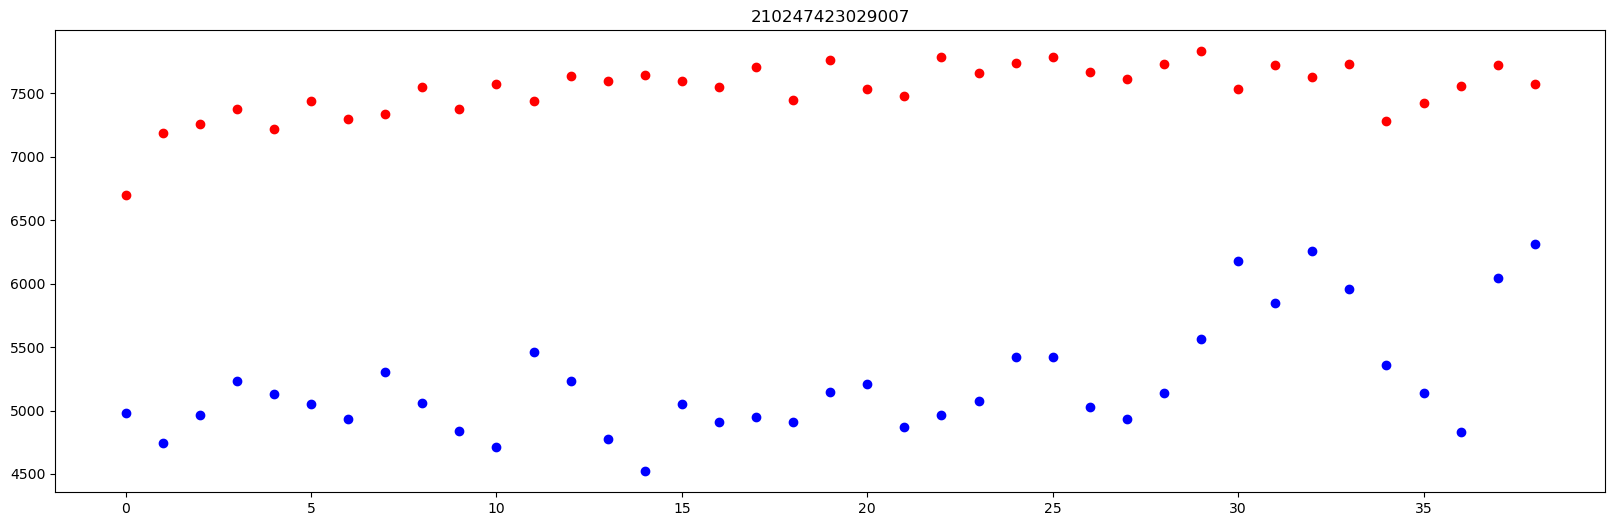

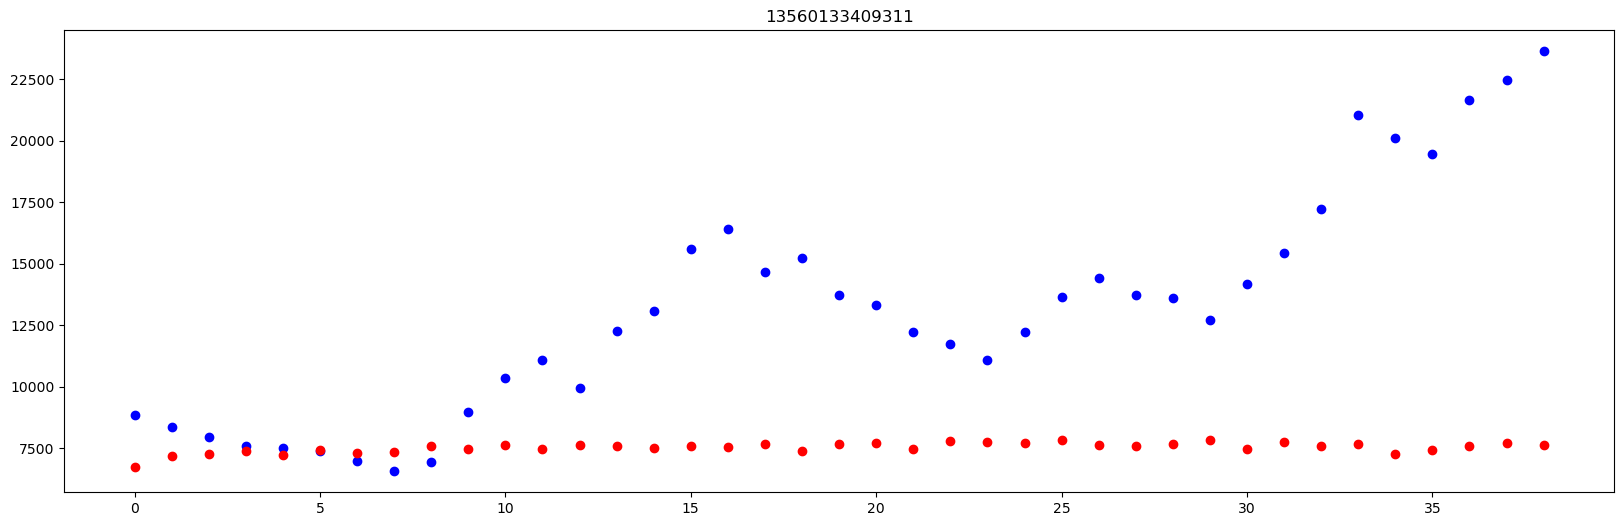

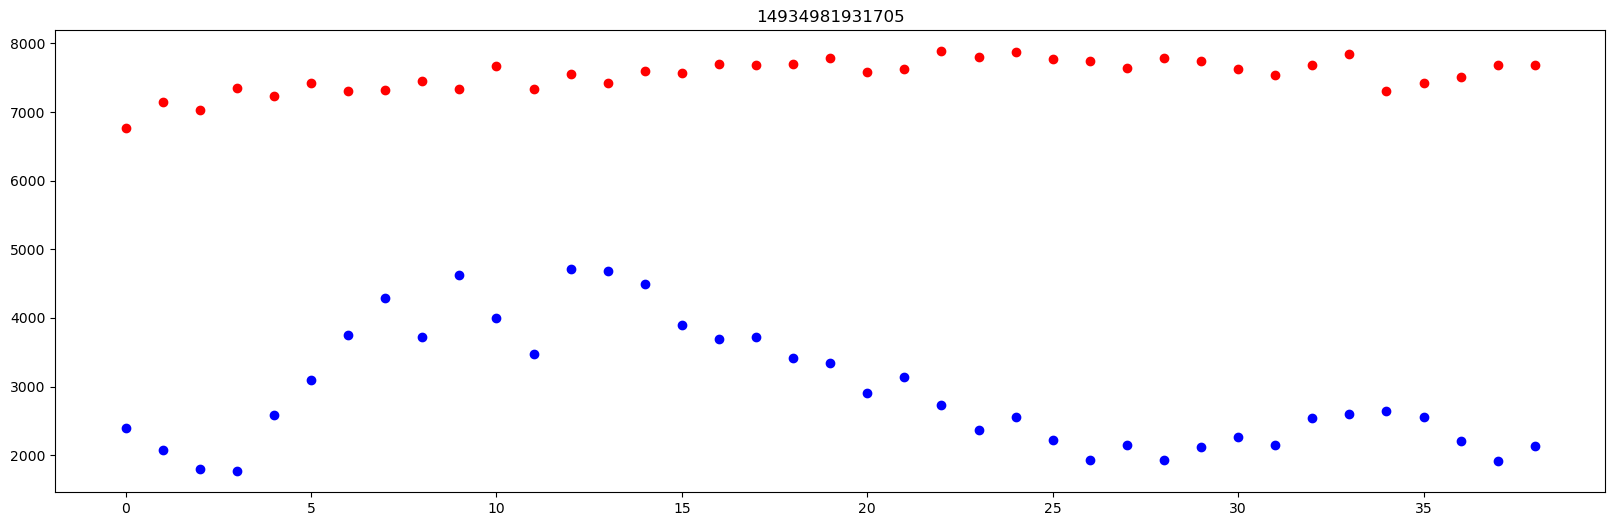

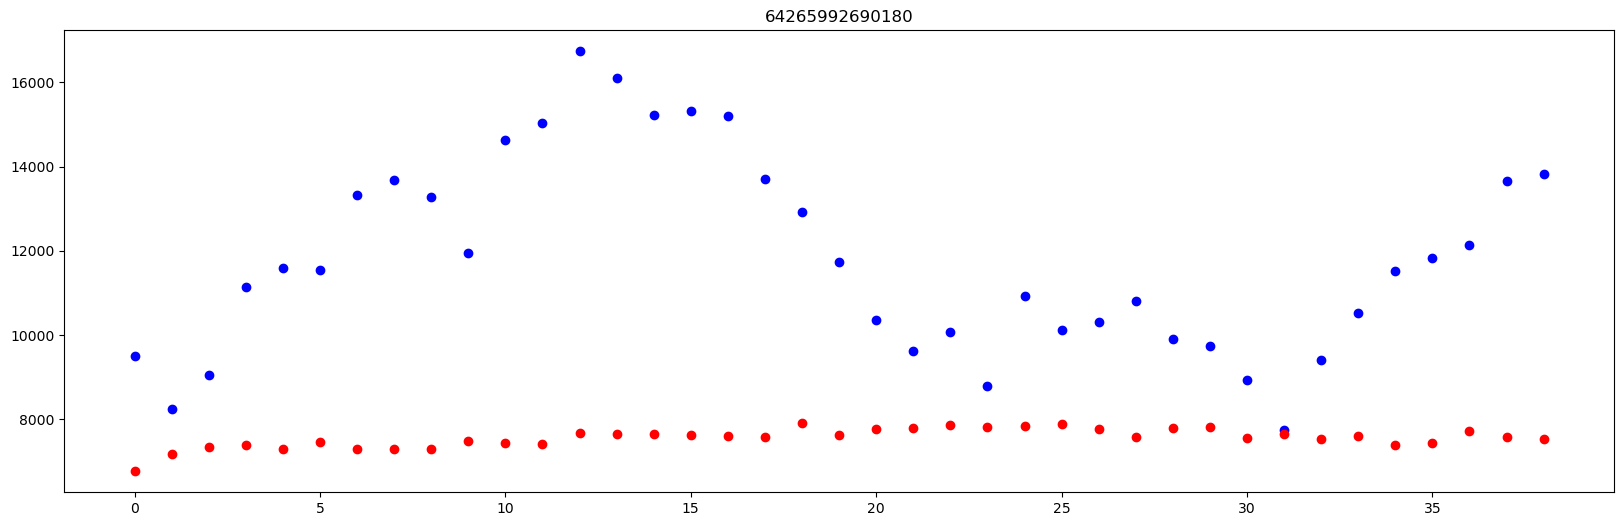

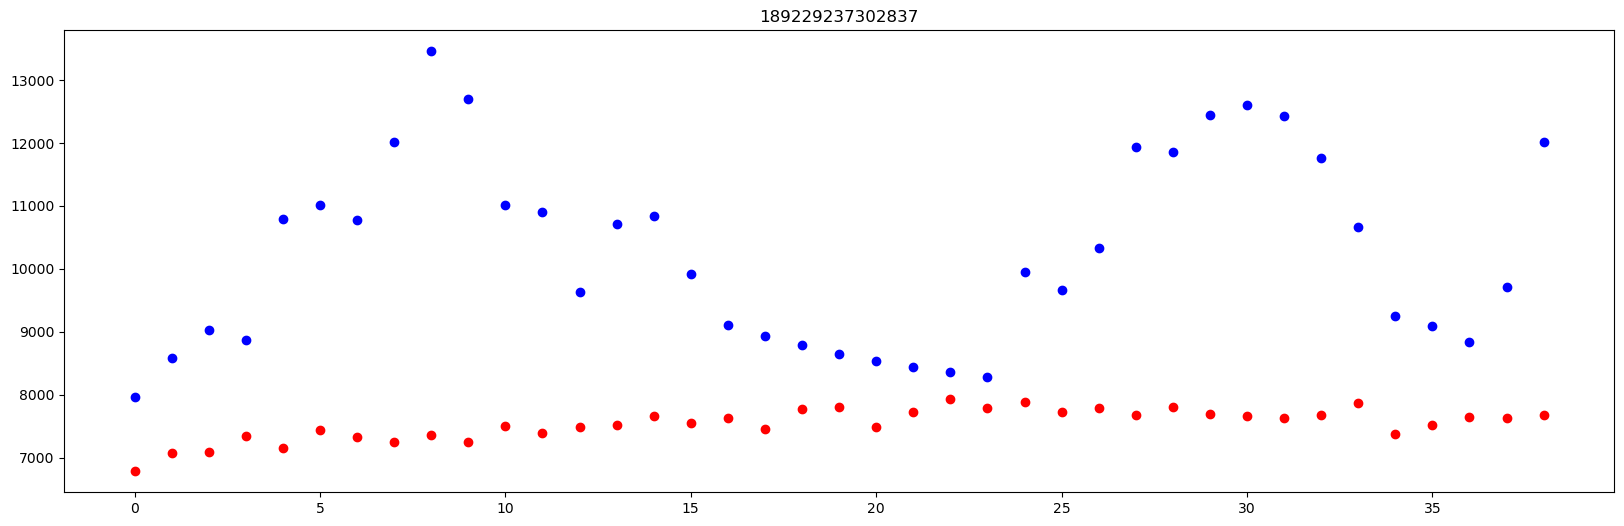

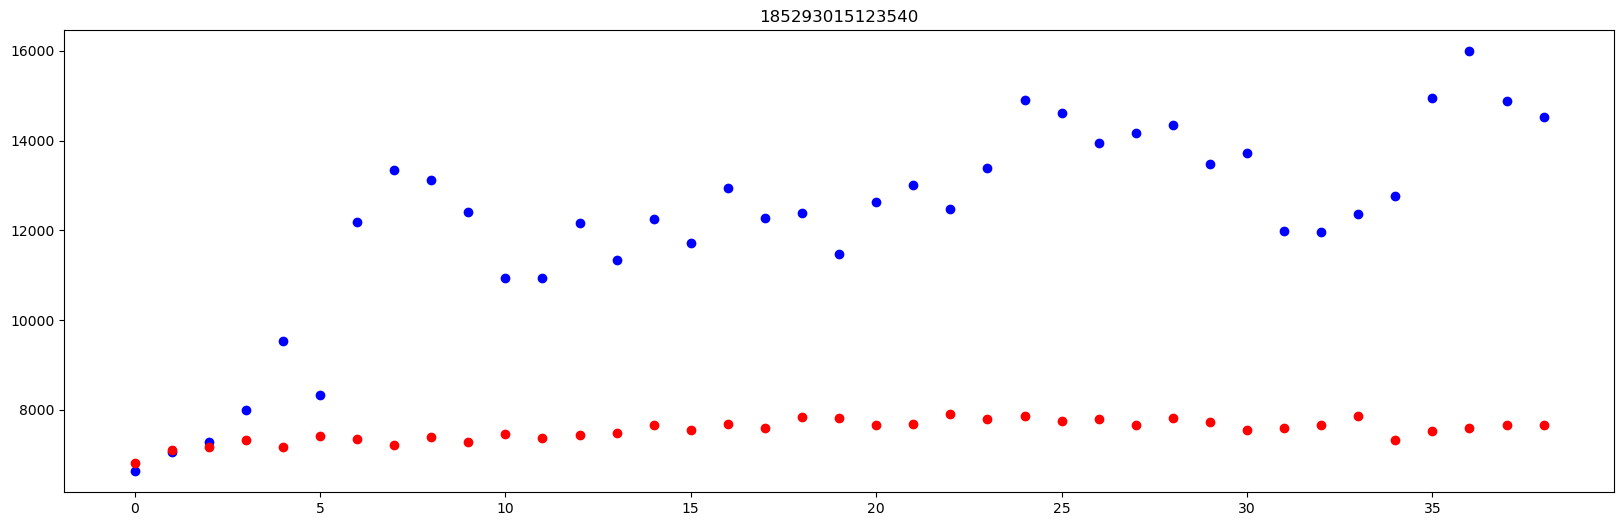

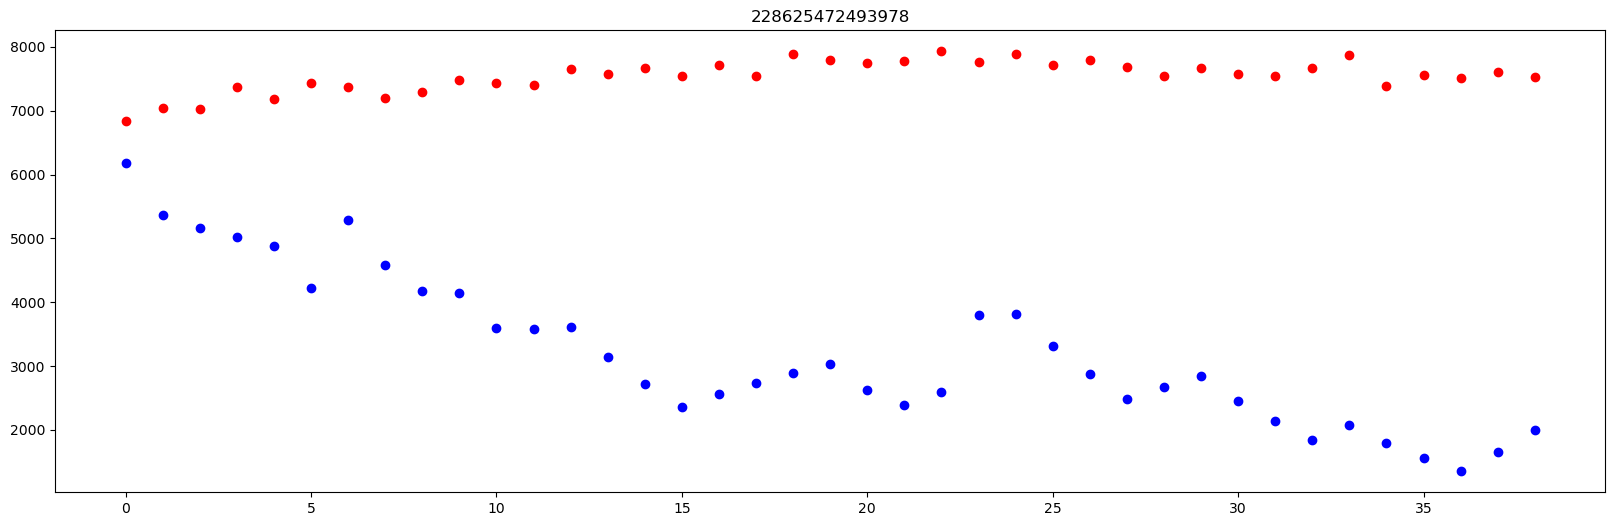

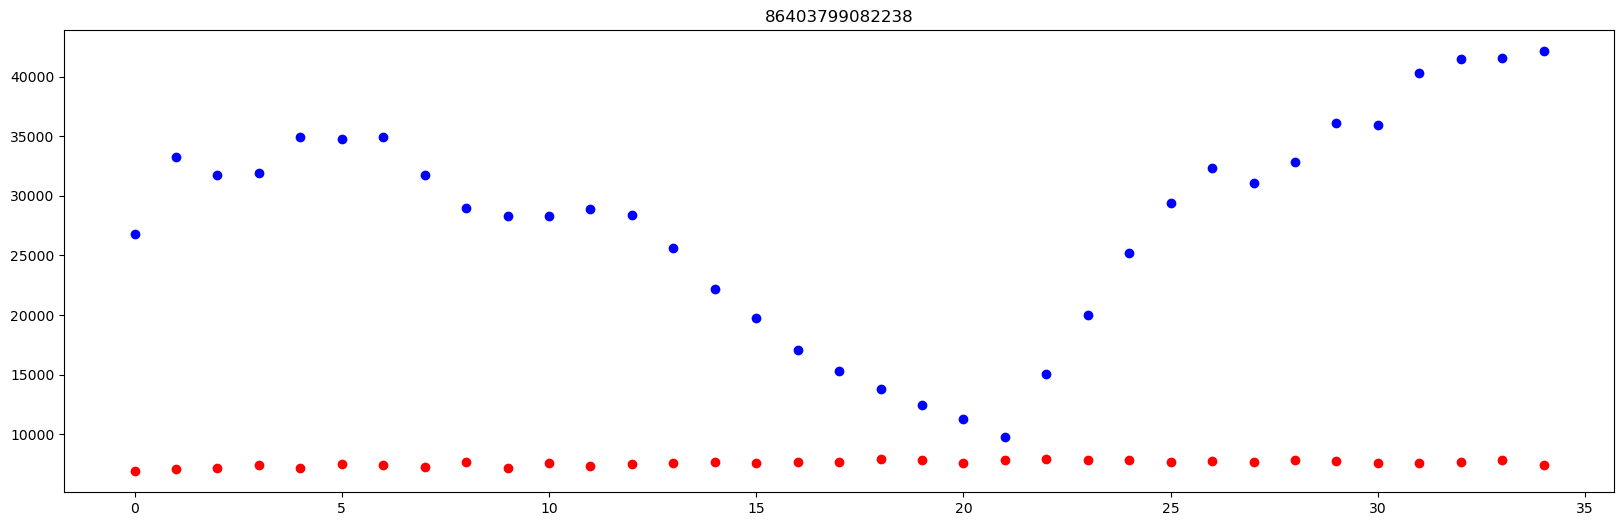

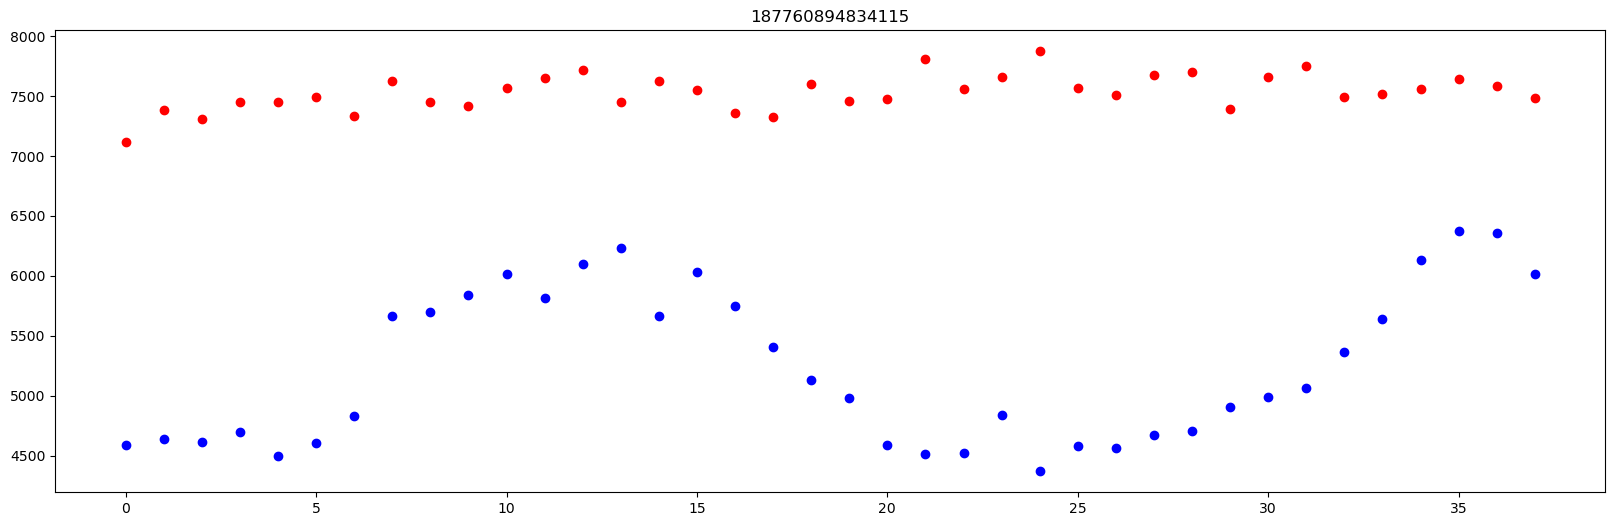

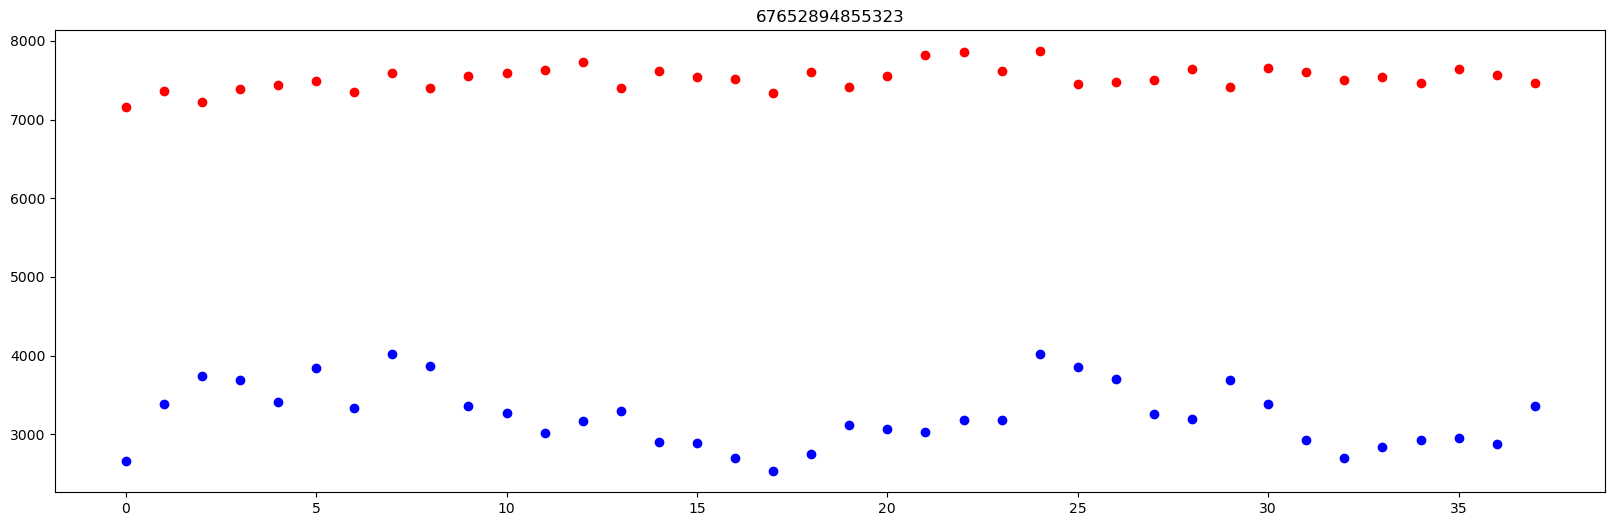

In [163]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)